In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import torch
import copy
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


In [2]:
## Dataset 1: HeartFailure

##1. Decision trees
##2. Neural networks
##3. Boosted Decision trees
##4. SVM (Support vector machines)
##5. KNN (K-nearest neighbors)

In [3]:
# read data from csv
df=pd.read_csv("heart.csv")
print(df.head()) #first 5 rows

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


In [4]:
#check string columns and update format from string to num
Sex=df['Sex'].unique()
print('Sex: ',Sex)

ChestPainType=df['ChestPainType'].unique()
print('ChestPainType: ',ChestPainType)

RestingECG=df['RestingECG'].unique()
print('RestingECG: ',RestingECG)

ExerciseAngina=df['ExerciseAngina'].unique()
print('ExerciseAngina: ',ExerciseAngina)

ST_Slope=df['ST_Slope'].unique()
print('ST_Slope: ',ST_Slope)

Sex:  ['M' 'F']
ChestPainType:  ['ATA' 'NAP' 'ASY' 'TA']
RestingECG:  ['Normal' 'ST' 'LVH']
ExerciseAngina:  ['N' 'Y']
ST_Slope:  ['Up' 'Flat' 'Down']


In [5]:
df['Sex']=df['Sex'].replace({'M':1,'F':0})
df['ChestPainType']=df['ChestPainType'].replace({'ATA':1,'NAP':2,'TA':3,'ASY':4})
df['RestingECG']=df['RestingECG'].replace({'Normal':1,'ST':2,'LVH':3})
df['ExerciseAngina']=df['ExerciseAngina'].replace({'Y':1,'N':0})
df['ST_Slope']=df['ST_Slope'].replace({'Up':1,'Flat':2,'Down':3})
print(df.head())

   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    1              1        140          289          0           1   
1   49    0              2        160          180          0           1   
2   37    1              1        130          283          0           2   
3   48    0              4        138          214          0           1   
4   54    1              2        150          195          0           1   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0    172               0      0.0         1             0  
1    156               0      1.0         2             1  
2     98               0      0.0         1             0  
3    108               1      1.5         2             1  
4    122               0      0.0         1             0  


In [6]:
#check outliers
# df['Age'].value_counts()
# df['Sex'].value_counts()
# df['ChestPainType'].value_counts()
# df['RestingBP'].value_counts()  #there is one abnormal record with 0 restBP, delete
# df['Cholesterol'].value_counts() #there are abnormal records with 0 restBP, delete
# df['FastingBS'].value_counts()
# df['RestingECG'].value_counts()
# df['MaxHR'].value_counts()
# df['ExerciseAngina'].value_counts()
# df['Oldpeak'].value_counts()
# df['ST_Slope'].value_counts()
# df['HeartDisease'].value_counts()



In [7]:
df=df.drop(df['RestingBP'][df['RestingBP']==0].index)
df=df.drop(df['Cholesterol'][df['Cholesterol']==0].index)

In [8]:
X = df.values[:,:-2] #columns and rows
y = df.values[:,-1] #target column
print("Number of positive samples: ", (y==1).sum())
print("Number of negative samples: ", (y==0).sum())
print("y shape: ", y.shape)
print("X shape: ", X.shape)

Number of positive samples:  356
Number of negative samples:  390
y shape:  (746,)
X shape:  (746, 10)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train.sum(), y_test.sum()

(243.0, 113.0)

In [10]:
print(X_train)

[[ 54.    1.    4.  ... 140.    0.    0. ]
 [ 53.    1.    2.  ... 160.    0.    0.3]
 [ 60.    1.    4.  ... 140.    1.    0.5]
 ...
 [ 45.    1.    4.  ... 140.    0.    0. ]
 [ 53.    1.    4.  ... 128.    1.    1.5]
 [ 40.    0.    4.  ... 130.    0.    2. ]]


In [11]:
##1. Decision trees
clf = tree.DecisionTreeClassifier() #load decision tree
clf.fit(X_train, y_train) #load training dataset
score=clf.score(X_test,y_test) #scoring using test dataset
print(score)

0.7633928571428571


In [14]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = tree.DecisionTreeClassifier()
parameters = {'max_depth': [1,2,3,4,5,6,7,8,9], #using different comb to find best parameters
              'max_leaf_nodes':range(20),
              'criterion':['gini','entropy'],
              'min_samples_leaf':range(15)}
gs = GridSearchCV(clf, parameters, refit = True, cv = 5, verbose = 1, n_jobs = -1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 5400 candidates, totalling 27000 fits
CPU times: user 3 s, sys: 196 ms, total: 3.2 s
Wall time: 5.86 s


/Users/a2085/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4320 fits failed out of a total of 27000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1350 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/a2085/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/a2085/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/Users/a2085/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/Users/a2085/anaconda3/l

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_leaf_nodes': range(0, 20),
                         'min_samples_leaf': range(0, 15)},
             verbose=1)

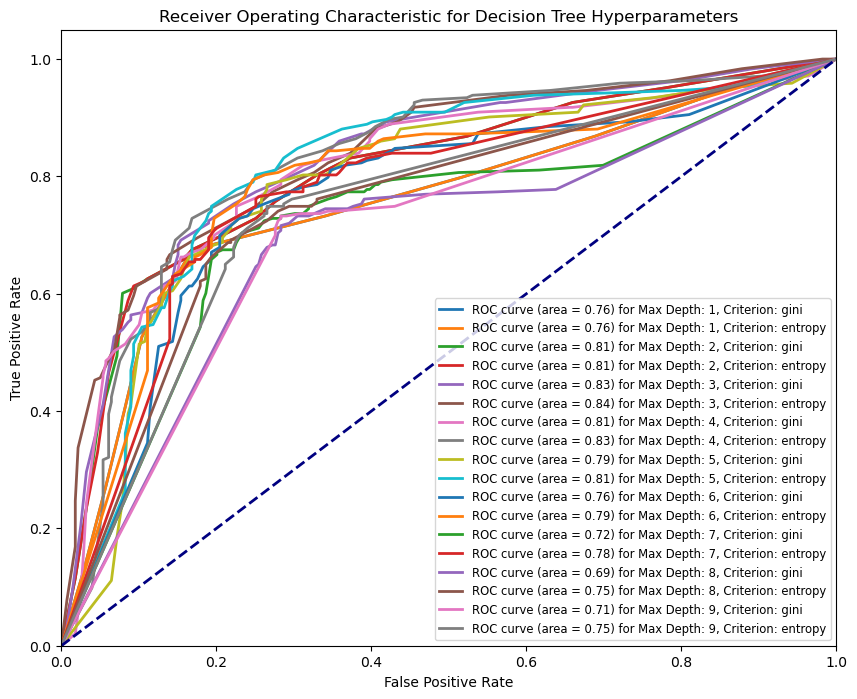

In [15]:
parameter_grid = {'max_depth': [1,2,3,4,5,6,7,8,9], 
              'criterion':['gini','entropy']
              }

parameter_combinations = list(itertools.product(*(parameter_grid[parameter] for parameter in parameter_grid)))

# Prepare to plot ROC curves
plt.figure(figsize=(10, 8))

# Iterate over each combination of parameters
for parameters in parameter_combinations:
    
    max_depth, criterion = parameters
    
    clf = tree.DecisionTreeClassifier(max_depth=max_depth, criterion=criterion)
    
    y_probas = cross_val_predict(clf, X_train, y_train, cv=5, method='predict_proba')
    
    fpr, tpr, _ = roc_curve(y_train, y_probas[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f) for Max Depth: %d, Criterion: %s' % (roc_auc, max_depth, criterion))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Decision Tree Hyperparameters')
plt.legend(loc="lower right", fontsize='small')
plt.show()

In [16]:
gs.best_score_ #best score

0.7853113553113553

In [17]:
gs.best_params_ #best score parameters

{'criterion': 'entropy',
 'max_depth': 5,
 'max_leaf_nodes': 18,
 'min_samples_leaf': 2}

In [18]:
clf = tree.DecisionTreeClassifier(criterion='entropy',
                                  max_depth=5,
                                  max_leaf_nodes=18,
                                  min_samples_leaf=12) #load decision tree with optimized parameters
clf.fit(X_train, y_train) #load training dataset
score=clf.score(X_test,y_test) #scoring using test dataset
print(score)

0.7857142857142857


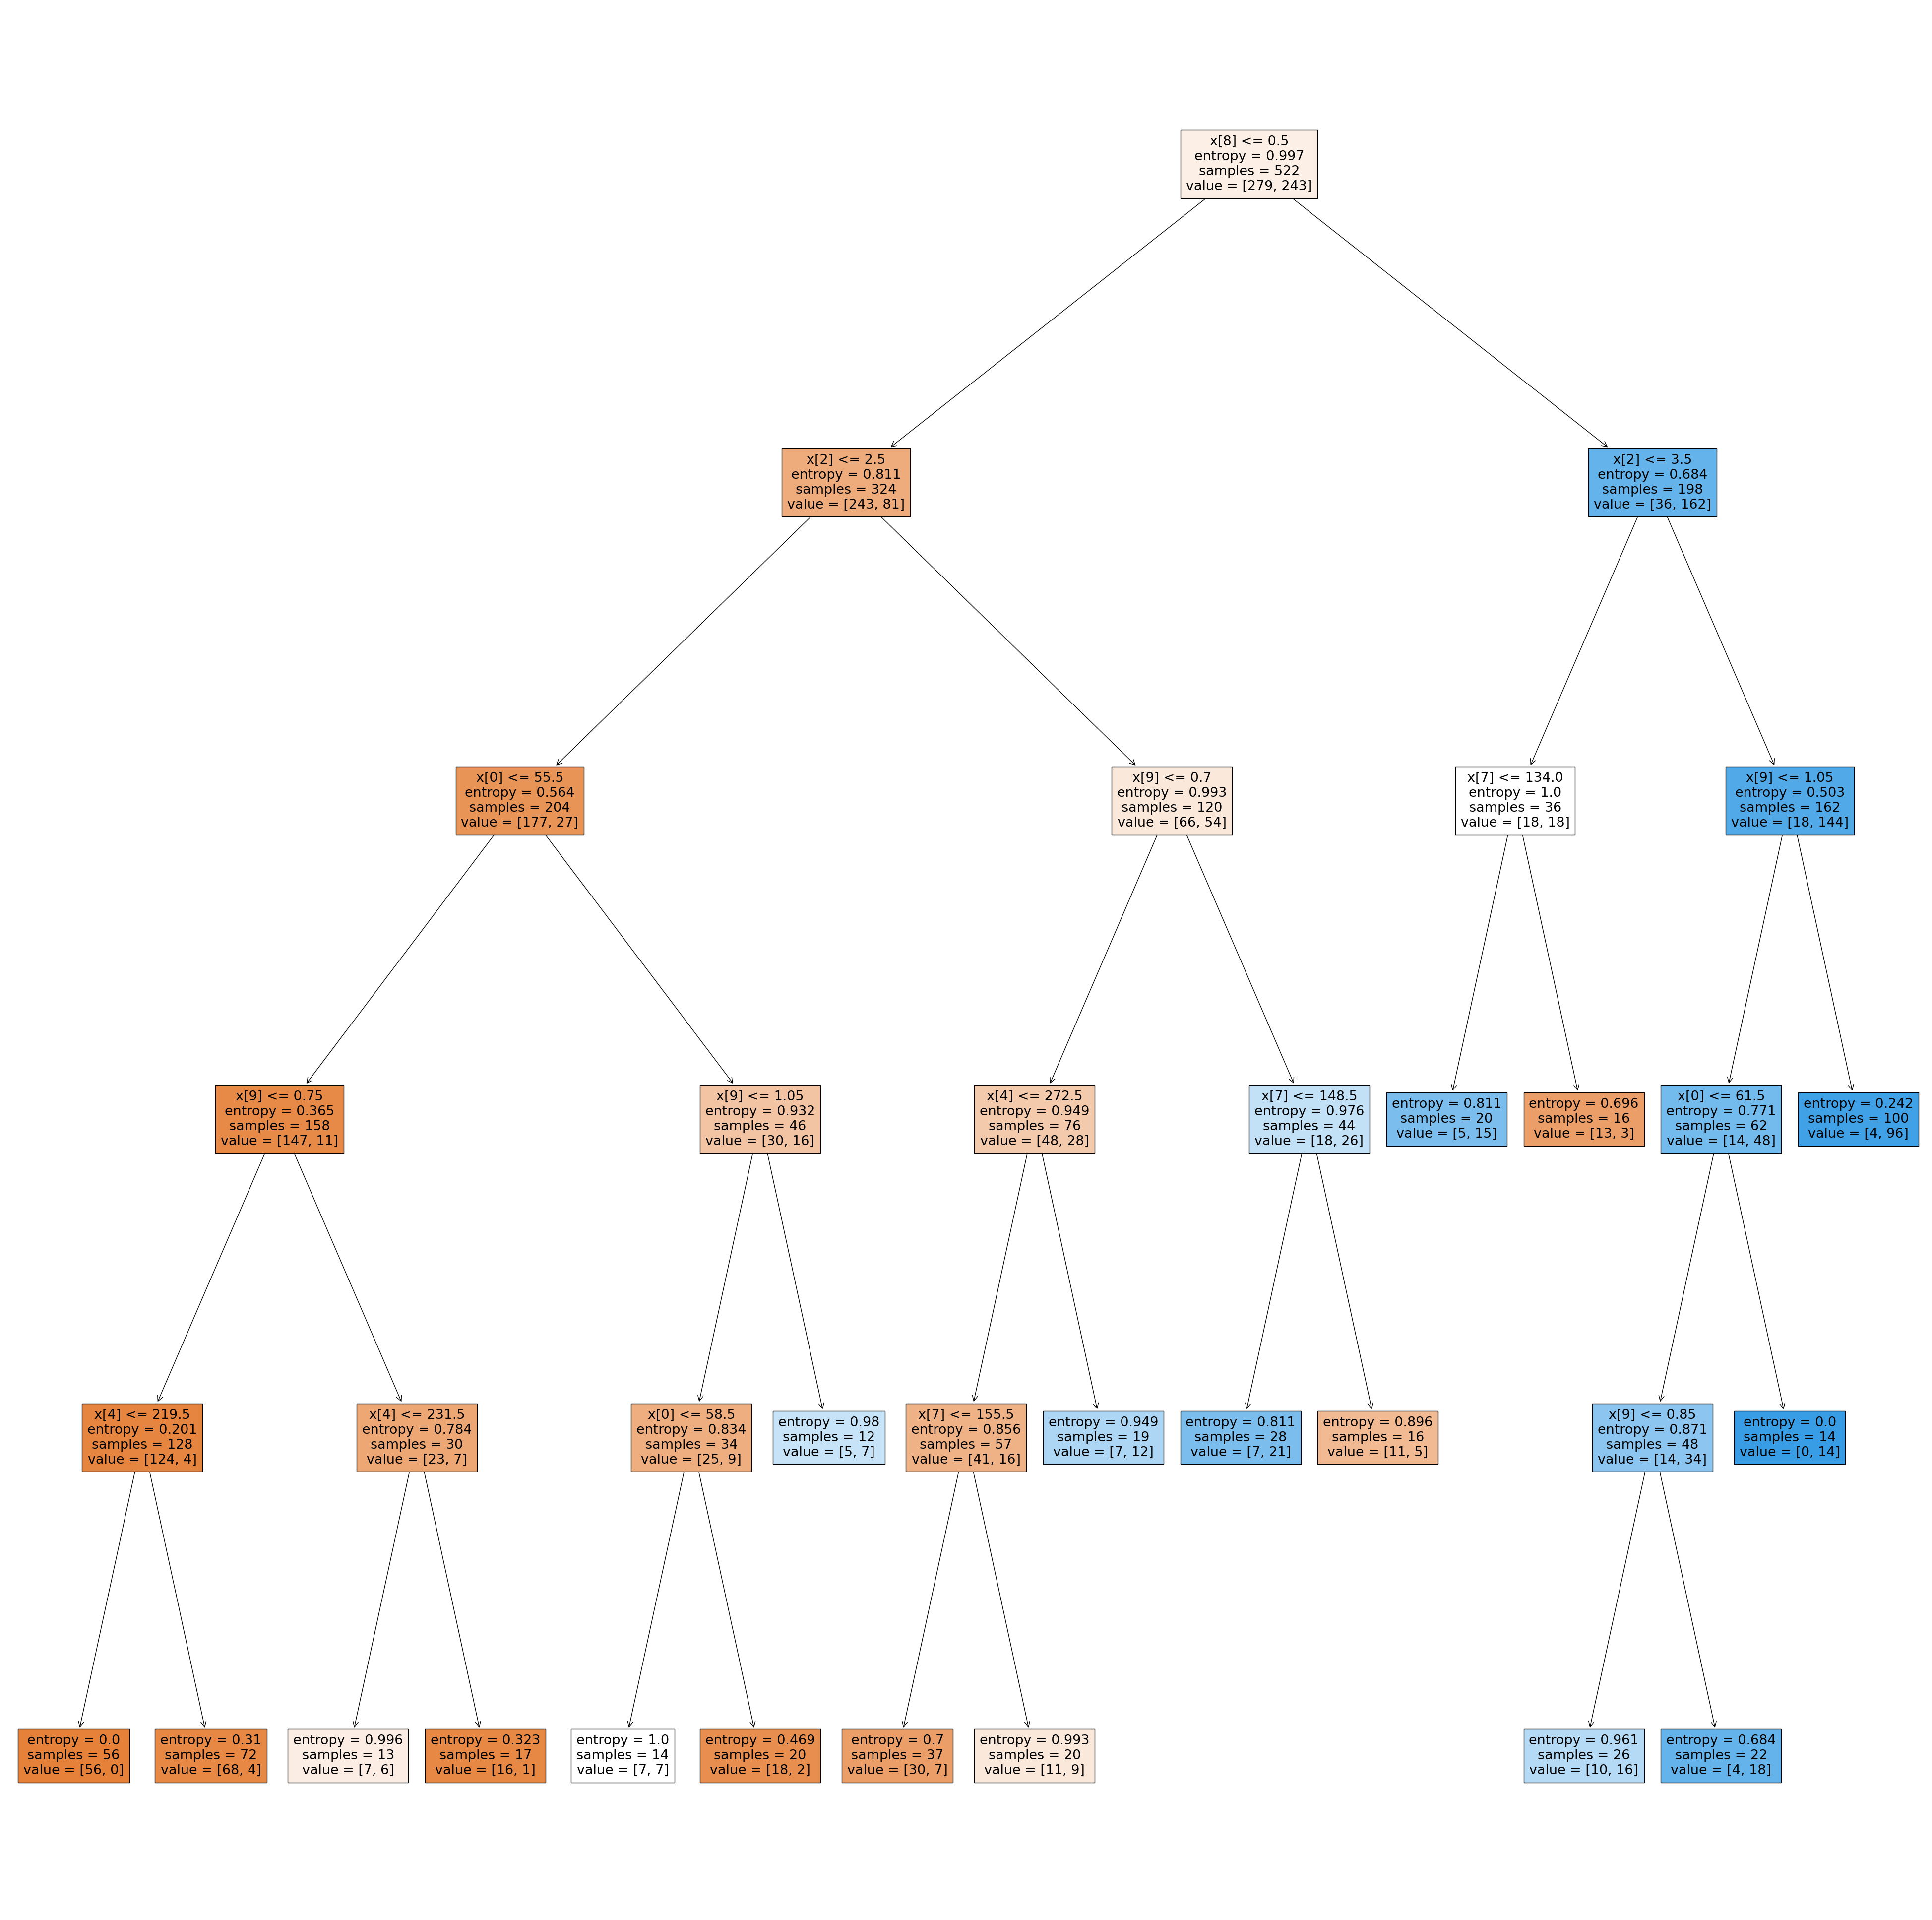

In [30]:
plt.figure(figsize=(50,50))
_ = tree.plot_tree(clf, filled=True)
plt.show()

In [19]:
#Final train and test scores
clf = tree.DecisionTreeClassifier(criterion='entropy',
                                  max_depth=5,
                                  max_leaf_nodes=18,
                                  min_samples_leaf=12) #load decision tree with optimized parameters
clf.fit(X_train, y_train) #load training dataset
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)
print("Test: ", roc_auc_score(y_test, y_test_predict))
print("Train: ", roc_auc_score(y_train, y_train_predict))

Test:  0.7860161046001755
Train:  0.8341962033718306


In [32]:
## 2. Neural networks

In [120]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [121]:
# Standardizing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [122]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# DataLoader
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

In [124]:
# Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

model = NeuralNetwork(X_train.shape[1]).to(device)

In [125]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 30
for epoch in tqdm(range(num_epochs)):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████████████████████████████████████| 30/30 [00:00<00:00, 190.03it/s]


In [126]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze()
    y_pred_labels = y_pred.round()
    test_auc = roc_auc_score(y_test.cpu(), y_pred_labels.cpu())
    print(f'Test ROC AUC Score: {test_auc}')

Test ROC AUC Score: 0.808538627122698


In [115]:
# Find best hyper parameters

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1) 
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

def train_and_evaluate_model(params):
    hidden_size, learning_rate, batch_size = params
    model = NeuralNetwork(X_train.shape[1], hidden_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    dataset = TensorDataset(X_train, y_train)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(num_epochs): 
        for inputs, targets in loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
    
    # Evaluation
    with torch.no_grad():
        outputs = model(X_test)
        auc_score = roc_auc_score(y_test.detach().numpy(), outputs.squeeze().detach().numpy())
    return auc_score

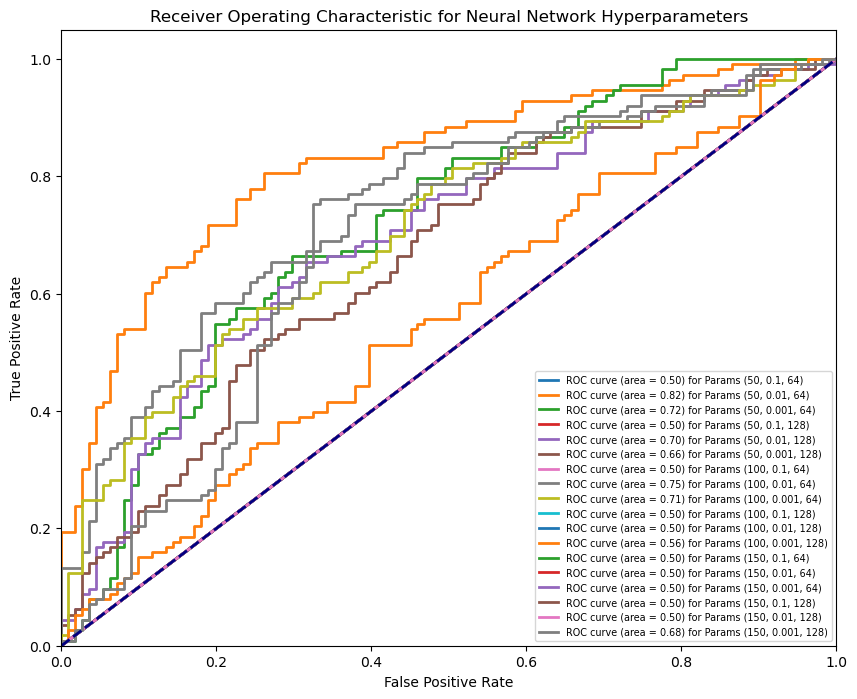

In [116]:
# Select different combinations of hyper parameters for ROC comparison
grid = [(50, 0.1, 64), 
        (50, 0.01, 64),
        (50, 0.001, 64),
        (50, 0.1, 128), 
        (50, 0.01, 128),
        (50, 0.001, 128),

        
        (100, 0.1, 64), 
        (100, 0.01, 64),
        (100, 0.001, 64),
        (100, 0.1, 128), 
        (100, 0.01, 128),
        (100, 0.001, 128),

        
        (150, 0.1, 64), 
        (150, 0.01, 64),
        (150, 0.001, 64),
        (150, 0.1, 128), 
        (150, 0.01, 128),
        (150, 0.001, 128),

       
       ]

# Adjusted training and evaluation function to include device handling
def train_and_evaluate_model(params, X_train, y_train, X_test, y_test, device):
    hidden_size, learning_rate, batch_size = params
    model = NeuralNetwork(X_train.shape[1], hidden_size).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Convert data to tensors and move to the designated device
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.FloatTensor(y_test).to(device)  # y_test is used later for roc_curve which expects numpy array
    
    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    num_epochs = 5  # Reduced for demonstration
    for epoch in range(num_epochs):
        for inputs, targets in loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor).squeeze()
        y_pred_proba = outputs.cpu().numpy()  # Move data back to CPU for sklearn metrics
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example data conversion (ensure X_train, y_train, X_test, y_test are correctly prepared before this step)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Iterate over each combination of parameters and collect ROC metrics
fprs, tprs, aucs = [], [], []
for params in grid:
    fpr, tpr, roc_auc = train_and_evaluate_model(params, X_train, y_train, X_test, y_test, device)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)

# Plotting ROC curves
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, roc_auc) in enumerate(zip(fprs, tprs, aucs)):
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f) for Params %s' % (roc_auc, str(grid[i])))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Neural Network Hyperparameters')
plt.legend(loc="lower right", fontsize='x-small')
plt.show()


In [80]:
## 3. Boosting Decision tree


In [129]:
##data loader
import xgboost as xgb
X = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the XGBoost model
xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

# Predictions and evaluation
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print("Training AUC: ", train_auc)
print("Test AUC: ", test_auc)

Training AUC:  1.0
Test AUC:  0.8706449812644503


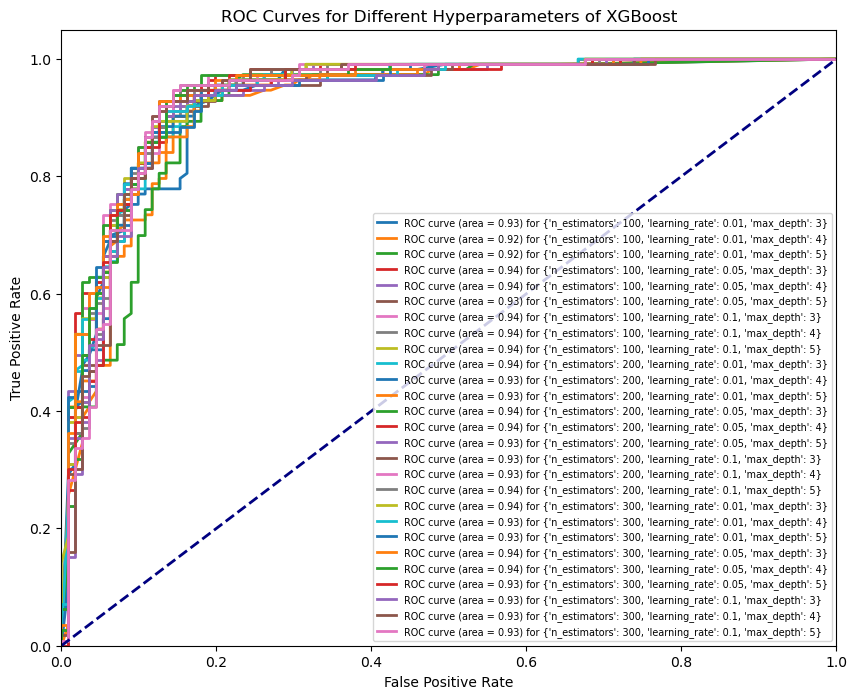

In [135]:
def train_model_and_get_roc(X_train, y_train, X_test, y_test, params):
    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Parameters grid setup (simplified for illustration)
parameter_combinations = list(itertools.product(
    parameters['n_estimators'],
    parameters['learning_rate'],
    parameters['max_depth']
))

# Plot setup
plt.figure(figsize=(10, 8))

# Iterate over parameter combinations
for combination in parameter_combinations:
    param_dict = {
        'n_estimators': combination[0],
        'learning_rate': combination[1],
        'max_depth': combination[2]
    }
    fpr, tpr, roc_auc = train_model_and_get_roc(X_train, y_train, X_test, y_test, param_dict)
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f) for %s' % (roc_auc, param_dict))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Hyperparameters of XGBoost')
plt.legend(loc="lower right", fontsize='x-small')
plt.show()


In [136]:
#find best hyper parameters
import xgboost as xgb
X = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


parameters = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage used to prevent overfitting
    'max_depth': [3, 4, 5],  # Maximum depth of a tree
    'colsample_bytree': [0.7, 0.8],  # Subsample ratio of columns when constructing each tree
    'subsample': [0.7, 0.8]  # Subsample ratio of the training instances
}

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Initialize GridSearchCV
grid_search = GridSearchCV(xgb_classifier,parameters, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best AUC found: ", grid_search.best_score_)

# Use the best estimator to make predictions
best_estimator = grid_search.best_estimator_
y_test_pred = best_estimator.predict(X_test)
test_auc = roc_auc_score(y_test, y_test_pred)

print("Test AUC: ", test_auc)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best AUC found:  0.9264262523191095
Test AUC:  0.8883440963086979


In [137]:

#retrain the model with optimized hyper parameters
import xgboost as xgb
X = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the XGBoost model
xgb = xgb.XGBClassifier(use_label_encoder=False, 
                        eval_metric='logloss',
                        colsample_bytree=0.7,
                        learning_rate=0.05,
                        max_depth=3,
                        n_estimators=100,
                        subsample=0.8
                        )
xgb.fit(X_train, y_train)

# Predictions and evaluation
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print("Training AUC: ", train_auc)
print("Test AUC: ", test_auc)

Training AUC:  0.9176290986326828
Test AUC:  0.8883440963086979


In [102]:
##4.SVM

In [139]:

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM Classifier
svm_clf = SVC(probability=True)  # probability=True to use roc_auc_score later

# Train the model
svm_clf.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_train_pred = svm_clf.predict(X_train_scaled)
y_test_pred = svm_clf.predict(X_test_scaled)

train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print("Training AUC: ", train_auc)
print("Test AUC: ", test_auc)


Training AUC:  0.9004380724810832
Test AUC:  0.8881846448218129


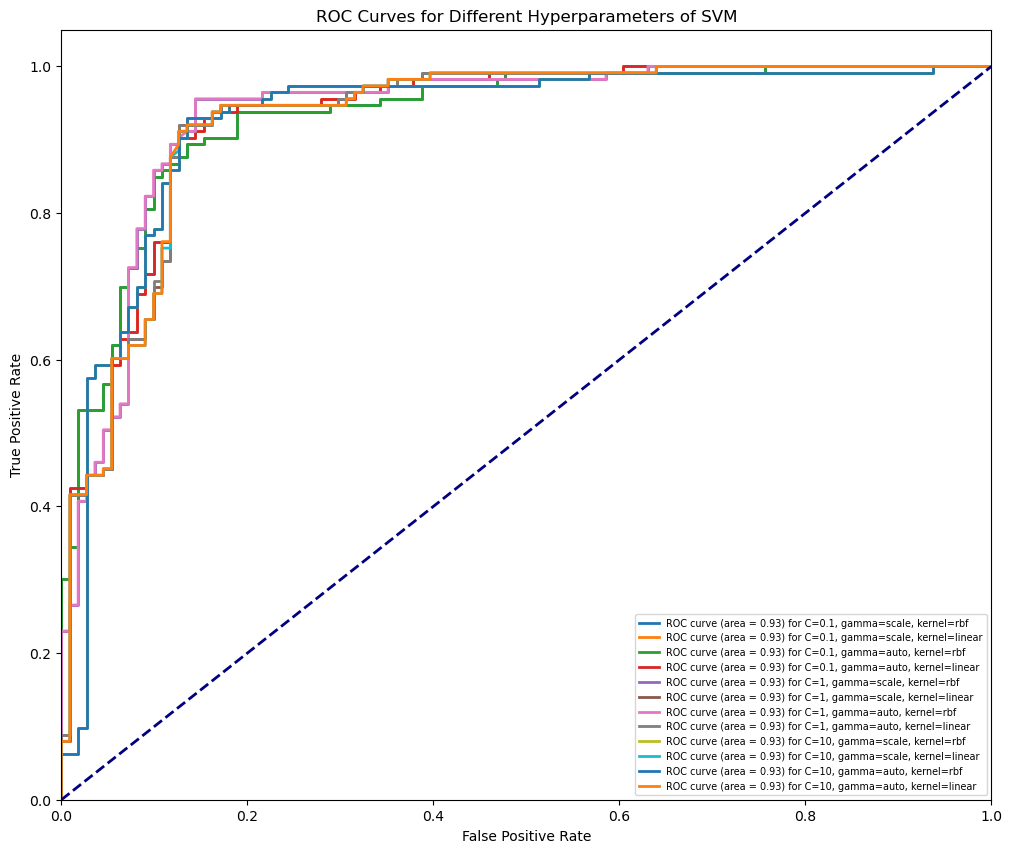

In [140]:
def train_svm_and_compute_roc(X_train, y_train, X_test, y_test, params):
    svm_clf = SVC(probability=True, **params)
    svm_clf.fit(X_train, y_train)
    y_scores = svm_clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Parameters for hyperparameter tuning
parameters = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

# Generate all combinations of parameters
parameter_combinations = list(itertools.product(parameters['C'], parameters['gamma'], parameters['kernel']))

# Plot setup
plt.figure(figsize=(12, 10))

# Iterate over parameter combinations
for combo in parameter_combinations:
    params = {'C': combo[0], 'gamma': combo[1], 'kernel': combo[2]}
    fpr, tpr, roc_auc = train_svm_and_compute_roc(X_train_scaled, y_train, X_test_scaled, y_test, params)
    label = f'ROC curve (area = {roc_auc:.2f}) for C={params["C"]}, gamma={params["gamma"]}, kernel={params["kernel"]}'
    plt.plot(fpr, tpr, lw=2, label=label)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Hyperparameters of SVM')
plt.legend(loc="lower right", fontsize='x-small')
plt.show()


In [141]:
# Hyperparameter tuning using GridSearchCV
parameters = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'kernel': ['rbf', 'linear']  # Specifies the kernel type to be used in the algorithm
}

grid_search = GridSearchCV(SVC(probability=True), parameters, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best AUC found: ", grid_search.best_score_)

# Use the best estimator to make predictions
best_estimator = grid_search.best_estimator_
y_test_pred = best_estimator.predict(X_test_scaled)
test_auc = roc_auc_score(y_test, y_test_pred)

print("Test AUC with best parameters: ", test_auc)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best AUC found:  0.9086638892570015
Test AUC with best parameters:  0.8704855297775652


In [142]:
# SVM Classifier
svm_clf = SVC(probability=True,
              C=0.1,
              gamma='scale',
              kernel='rbf'
             ) 

# Train the model
svm_clf.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_train_pred = svm_clf.predict(X_train_scaled)
y_test_pred = svm_clf.predict(X_test_scaled)

train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print("Training AUC: ", train_auc)
print("Test AUC: ", test_auc)

Training AUC:  0.8503916102482412
Test AUC:  0.8704855297775652


In [110]:
##5. KNN

In [145]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN Classifier
knn_clf = KNeighborsClassifier()

# Train the model
knn_clf.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_train_pred = knn_clf.predict(X_train_scaled)
y_test_pred = knn_clf.predict(X_test_scaled)

train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print("Training AUC: ", train_auc)
print("Test AUC: ", test_auc)


Training AUC:  0.8750829682729325
Test AUC:  0.8971936538308218


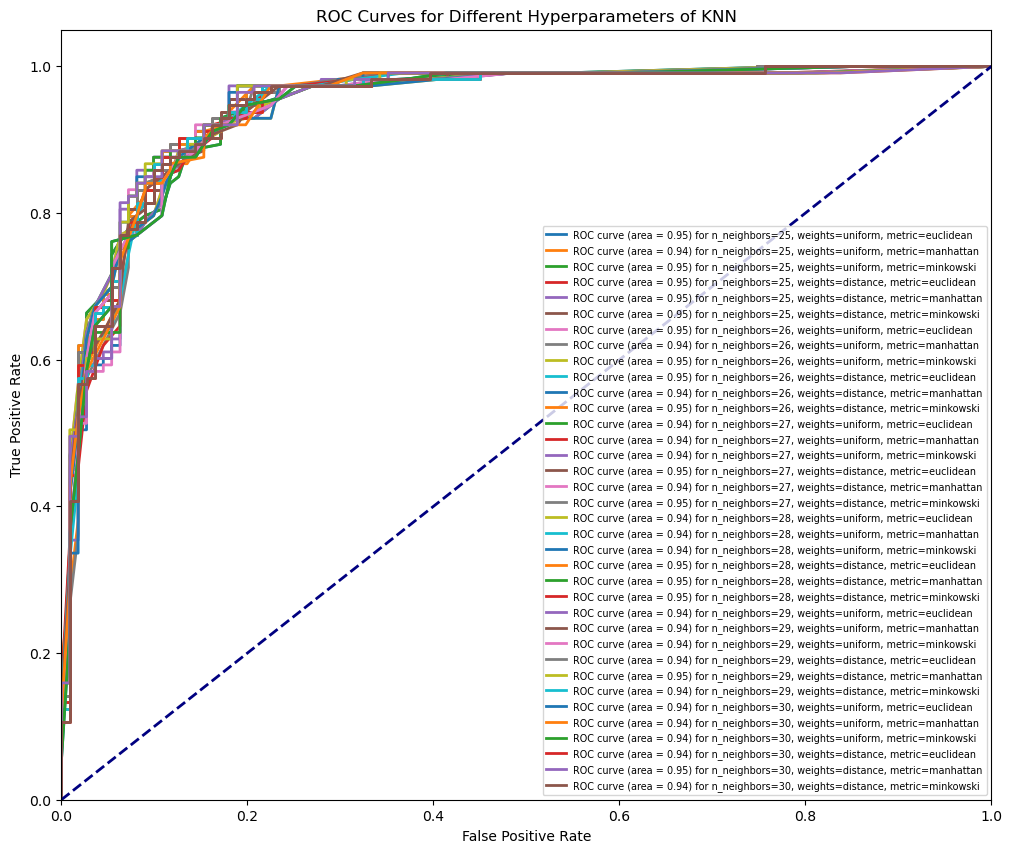

In [150]:
## ROC curves plot
def train_knn_and_compute_roc(X_train, y_train, X_test, y_test, params):
    knn_clf = KNeighborsClassifier(**params)
    knn_clf.fit(X_train, y_train)
    # For KNN, using predict_proba to get scores for ROC curve
    y_scores = knn_clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Parameters for hyperparameter tuning
parameters = {
    'n_neighbors': range(25, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Generate all combinations of parameters
parameter_combinations = list(itertools.product(
    parameters['n_neighbors'],
    parameters['weights'],
    parameters['metric']
))

# Plot setup
plt.figure(figsize=(12, 10))

# Iterate over parameter combinations
for combo in parameter_combinations:
    params = {'n_neighbors': combo[0], 'weights': combo[1], 'metric': combo[2]}
    fpr, tpr, roc_auc = train_knn_and_compute_roc(X_train_scaled, y_train, X_test_scaled, y_test, params)
    label = f'ROC curve (area = {roc_auc:.2f}) for n_neighbors={params["n_neighbors"]}, weights={params["weights"]}, metric={params["metric"]}'
    plt.plot(fpr, tpr, lw=2, label=label)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Hyperparameters of KNN')
plt.legend(loc="lower right", fontsize='x-small')
plt.show()


In [151]:

# Hyperparameter tuning using GridSearchCV
parameters = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best AUC found: ", grid_search.best_score_)

# Use the best estimator to make predictions
best_estimator = grid_search.best_estimator_
y_test_pred = best_estimator.predict(X_test_scaled)
test_auc = roc_auc_score(y_test, y_test_pred)

print("Test AUC with best parameters: ", test_auc)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 27, 'weights': 'distance'}
Best AUC found:  0.9164383448184468
Test AUC with best parameters:  0.8885035477955833


In [152]:
# Retain with best hyper parameters
knn_clf = KNeighborsClassifier(metric='manhattan',
                              n_neighbors=27,
                              weights='distance')

# Train the model
knn_clf.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_train_pred = knn_clf.predict(X_train_scaled)
y_test_pred = knn_clf.predict(X_test_scaled)

train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print("Training AUC: ", train_auc)
print("Test AUC: ", test_auc)


Training AUC:  1.0
Test AUC:  0.8885035477955833
